In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 31 13:48:10 2022

@author: lisav
"""

from Model import plot_metric
from Model import create_model

import csv
import numpy as np
import pandas as pd
from pickle import dump, load
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from sklearn.utils import class_weight

np.random.seed(1258)  # for reproducibility

2023-11-08 18:42:50.328587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 18:42:50.560726: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 18:42:50.597120: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 18:42:51.137943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# change last folder name by respective batches
save_file_path = '../data/model-results-notest/'

if not os.path.exists(save_file_path):
    os.mkdir(save_file_path)
    os.mkdir(save_file_path + 'checkpoints/')
    print('-----Directory made-----')
else:
    print('-----Directory already exists-----')

-----Directory made-----


In [3]:
print('Loading train-validation-test sequences and labels!')

# load 1st batch data
train_seq = []
train_label = []
val_seq = [] 
val_label = []

train_seq = np.load('../data/split-train-val/train-features-scaled.npz')['arr_0']
train_label = np.load('../data/split-train-val/train-labels.npz')['arr_0']

val_seq = np.load('../data/split-train-val/validation-features-scaled.npz')['arr_0']
val_label = np.load('../data/split-train-val/validation-labels.npz')['arr_0']

Loading train-validation-test sequences and labels!


In [4]:
# Create and train the model
model = create_model(train_seq[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 100)           8500      
                                                                 
 dropout (Dropout)           (None, 35, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 34, 100)           20100     
                                                                 
 dropout_1 (Dropout)         (None, 34, 100)           0         
                                                                 
 attention (attention)       (None, 34, 100)           134       
                                                                 
 bidirectional (Bidirectiona  (None, 34, 200)          160800    
 l)                                                              
                                                        

In [5]:
history = History()
model_checkpoint = ModelCheckpoint(filepath = save_file_path + 'tada.{epoch:02d}-{val_loss:.2f}.hdf5',\
        save_weights_only=True,\
            monitor='val_loss',\
                mode='auto',\
                    save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

callbacks = [
    history,
    model_checkpoint,
    earlystopper
]

In [6]:
#class weights
ground_truth = np.argmax(train_label, axis=-1)
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(ground_truth), \
    y = ground_truth)
d_class_weights = dict(enumerate(class_weights))

In [7]:
history = model.fit(train_seq, train_label, batch_size=64,
                    epochs=20, verbose=1, callbacks=callbacks,
                    class_weight = d_class_weights,
                    validation_data=(val_seq, val_label))

Epoch 1/20
969/969 [==============================] - 113s 109ms/step - loss: 0.0331 - precision: 0.9157 - recall: 0.9157 - auc: 0.9629 - accuracy: 0.9157 - aupr: 0.9591 - f1_metric: 0.9157 - val_loss: 0.0281 - val_precision: 0.9176 - val_recall: 0.9176 - val_auc: 0.9711 - val_accuracy: 0.9176 - val_aupr: 0.9685 - val_f1_metric: 0.9177
Epoch 2/20
969/969 [==============================] - 104s 107ms/step - loss: 0.0288 - precision: 0.9220 - recall: 0.9220 - auc: 0.9698 - accuracy: 0.9220 - aupr: 0.9665 - f1_metric: 0.9220 - val_loss: 0.0291 - val_precision: 0.9208 - val_recall: 0.9208 - val_auc: 0.9715 - val_accuracy: 0.9208 - val_aupr: 0.9691 - val_f1_metric: 0.9208
Epoch 3/20
969/969 [==============================] - 104s 107ms/step - loss: 0.0282 - precision: 0.9235 - recall: 0.9235 - auc: 0.9704 - accuracy: 0.9235 - aupr: 0.9672 - f1_metric: 0.9235 - val_loss: 0.0262 - val_precision: 0.9279 - val_recall: 0.9279 - val_auc: 0.9728 - val_accuracy: 0.9279 - val_aupr: 0.9702 - val_f1_m

In [8]:
model.save('classification_tada.h5')

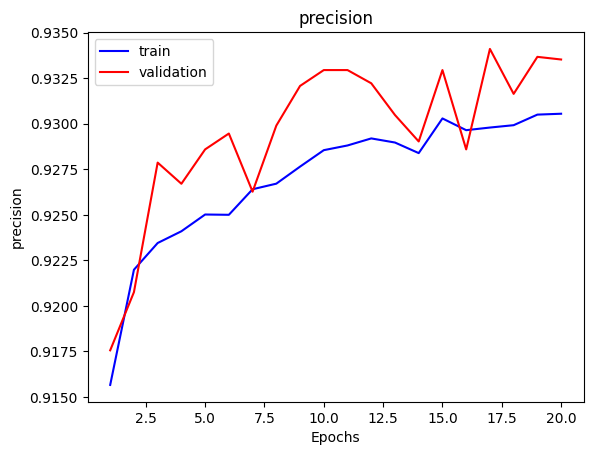

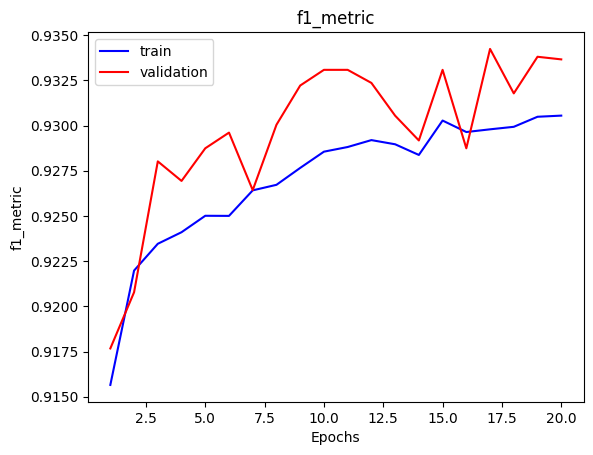

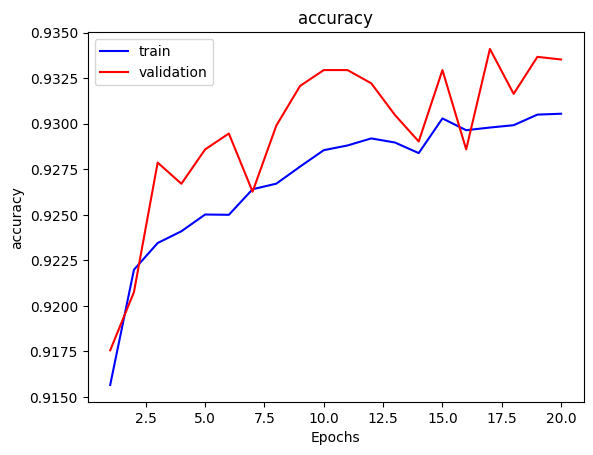

In [9]:
# Plot metrics
model_history = pd.DataFrame(history.history)
training_precision = model_history['precision']#.values()
validation_precision = model_history['val_precision']#.values()
plot_metric(training_precision, validation_precision, 'precision')

training_f1 = model_history['f1_metric']#.values()
validation_f1 = model_history['val_f1_metric']#.values()
plot_metric(training_f1, validation_f1, 'f1_metric')

training_accuracy = model_history['accuracy']#.values()
validation_accuracy = model_history['val_accuracy']#.values()
plot_metric(training_accuracy, validation_accuracy, 'accuracy')